### https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9762926

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd

import settings as s
from common import get_weights
from communities import get_communities_spark
from features import generate_features_spark, generate_features_udf_wrapper, SCHEMA_FEAT_UDF

%load_ext autoreload
%autoreload 2

In [2]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [3]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/27 19:24:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61088)
Traceback (most recent call last):
  File "/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  F

In [4]:
data = pd.read_csv("./data/Libra_bank_3months_graph/data.csv")
rename = {
    "id_source": "source",
    "id_destination": "target",
    "cum_amount": "amount",
    "nr_transactions": "num_transactions",
    "nr_alerts": "alerts_count",
    "nr_reports": "reports_count",
}

data = data.rename(columns=rename)
data.loc[:, "source_"] = (
    data.loc[:, "source"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
data.loc[:, "target_"] = (
    data.loc[:, "target"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
del data["source"]
del data["target"]
data = data.rename(
    columns={
        "source_": "source",
        "target_": "target",
    }
).loc[:, ["source", "target", "amount", "num_transactions", "alerts_count", "reports_count"]]

In [5]:
nodes_data = pd.DataFrame(index=sorted(set(data["source"].tolist() + data["target"].tolist())))
nodes_data.index.name = "key"

w_alerts = int(data["alerts_count"].sum() * 2)
w_reports = int(data["reports_count"].sum() * 2)

w_alerts_source = data[data["alerts_count"] > 0].groupby("source").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]
w_alerts_target = data[data["alerts_count"] > 0].groupby("target").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]

w_reports_source = data[data["reports_count"] > 0].groupby("source").agg({"reports_count": "sum"}).to_dict()["reports_count"]
w_reports_target = data[data["reports_count"] > 0].groupby("target").agg({"reports_count": "sum"}).to_dict()["reports_count"]

nodes_data.loc[:, "alert_weight"] = nodes_data.index.map(
    lambda x: (w_alerts_source.get(x, 0) + w_alerts_target.get(x, 0)) / w_alerts
)
nodes_data.loc[:, "report_weight"] = nodes_data.index.map(
    lambda x: (w_reports_source.get(x, 0) + w_reports_target.get(x, 0)) / w_reports
)
alerted_nodes = set(nodes_data[nodes_data["alert_weight"] > 0].index)

In [6]:
total_nodes = nodes_data.shape[0]
perc_point_1_cnt = round(total_nodes * (0.1 / 100))
perc_point_2_cnt = round(total_nodes * (0.2 / 100))
perc_point_5_cnt = round(total_nodes * (0.5 / 100))
perc_1_cnt = round(total_nodes * (1 / 100))
perc_10_cnt = round(total_nodes * (10 / 100))
perc_20_cnt = round(total_nodes * (20 / 100))
perc_30_cnt = round(total_nodes * (30 / 100))
perc_40_cnt = round(total_nodes * (40 / 100))
perc_50_cnt = round(total_nodes * (50 / 100))
perc_75_cnt = round(total_nodes * (75 / 100))
print(total_nodes, perc_point_1_cnt, perc_point_2_cnt, perc_point_5_cnt, perc_1_cnt)

385100 385 770 1926 3851


In [7]:
%%time

candidates = nodes_data.index.tolist()
data_in_scope = data.copy(deep=True)
data_in_scope = data_in_scope.set_index(["source", "target"]).join(
    get_weights(data_in_scope).set_index(["source", "target"]), how="left"
).reset_index()
data_in_scope.loc[:, "amount_weighted"] = (
    data_in_scope.loc[:, "amount"] * 
    (data_in_scope.loc[:, "weight"] / data_in_scope.loc[:, "weight"].max())
)

%run model.ipynb

anomalies_main = anomalies.copy(deep=True)

25/07/27 19:24:50 WARN TaskSetManager: Stage 0 contains a task of very large size (3851 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 472,592 | 213,511
Processed hop #2 | 6,730,058 | 194,847
Processed hop #3 | 7,805,533 | 186,398
Processed hop #4 | 8,894,931 | 185,538
Processed hop #5 | 8,889,368 | 185,321

Processing comm_as_target

Processed hop #1 | 414,376 | 221,458
Processed hop #2 | 6,111,806 | 201,104
Processed hop #3 | 7,163,788 | 188,404
Processed hop #4 | 8,469,276 | 186,909
Processed hop #5 | 8,208,835 | 183,360

Processing comm_as_passthrough

Processed hop #1 | 251,417 | 49,869
Processed hop #2 | 1,310,227 | 42,290
Processed hop #3 | 1,725,981 | 40,671
Processed hop #4 | 1,918,895 | 40,412
Processed hop #5 | 1,952,010 | 40,363

Processing comm_as_passthrough_reverse

Processed hop #1 | 197,559 | 49,869
Processed hop #2 | 1,081,845 | 41,267
Processed hop #3 | 1,434,805 | 38,874
Processed hop #4 | 1,719,403 | 38,462
Processed hop #5 | 1,722,034 | 38,030


comm_as_source_features

CPU times: user 32.3 s, sys: 354 ms, total: 32.7 s
Wall time: 32.7 s

comm_as_tar

CPU times: user 2.02 s, sys: 78.8 ms, total: 2.1 s
Wall time: 23.2 s
Leiden communitites features creation


CPU times: user 5.02 s, sys: 657 ms, total: 5.68 s
Wall time: 38.9 s
1-hop communitites features creation


CPU times: user 2min 16s, sys: 23.3 s, total: 2min 39s
Wall time: 5min 24s
1-hop-source features creation


25/07/27 19:43:26 WARN TaskSetManager: Stage 12 contains a task of very large size (6867 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.65 s, sys: 223 ms, total: 1.87 s
Wall time: 1min 12s
1-hop-target features creation


25/07/27 19:44:38 WARN TaskSetManager: Stage 15 contains a task of very large size (6961 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.69 s, sys: 241 ms, total: 1.94 s
Wall time: 1min 15s
Features: (385100, 176)
Deleted 10 constant columns
Script executed in 0:21:09
Training the model
CPU times: user 11min 8s, sys: 50.6 s, total: 11min 59s
Wall time: 11min 59s
CPU times: user 25min 13s, sys: 1min 53s, total: 27min 6s
Wall time: 33min 13s


In [8]:
graph_global = ig.Graph.DataFrame(data[["source", "target"]], use_vids=False, directed=True)

In [9]:
def add_predicted_alert_weight(anomalies_input, perc_count_in):
    anomalies_perc_x = anomalies_input.copy(deep=True)
    index = anomalies_perc_x.head(perc_count_in).index.tolist()
    anomalies_perc_x = anomalies_perc_x.loc[index, :]
    anomalies_perc_x.loc[:, "predicted_alert_weight"] = anomalies_perc_x.loc[:, "alert_weight"]
    anomalies_perc_x.loc[:, "predicted_report_weight"] = anomalies_perc_x.loc[:, "report_weight"]
    return anomalies_perc_x

In [10]:
communities_1_hop_dict = dict(communities_1_hop)

comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_1_cnt).index]
comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_2_cnt).index]
comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_5_cnt).index]
comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_1_cnt).index]

sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]

sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

tpr = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"]).values
tpr_report = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"]).values

results = [{
    "rectify_perc": 1.0,
    "sizes_1_hop_alerted": sizes_1_hop_alerted,
    "leiden_size_max": np.max(sizes_leiden),
    "leiden_size_mean": np.mean(sizes_leiden),
    "leiden_size_median": np.median(sizes_leiden),
    "1_hop_size_max": np.max(sizes_1_hop),
    "1_hop_size_mean": np.mean(sizes_1_hop),
    "1_hop_size_median": np.median(sizes_1_hop),
    "0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_alert_weight"].sum(),
    "0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_alert_weight"].sum(),
    "0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_alert_weight"].sum(),
    "1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"].sum(),
    "tpr_1%": tpr,
    "tpr_auc_1%": np.mean(tpr),
    "report_0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_report_weight"].sum(),
    "report_0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_report_weight"].sum(),
    "report_0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_report_weight"].sum(),
    "report_1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"].sum(),
    "tpr_report_1%": tpr_report,
    "tpr_report_auc_1%": np.mean(tpr_report),
    "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
    "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
    "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
    "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
    "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
    "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
    "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
    "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
    "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
    "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
    "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
    "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
    "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
    "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
    "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
    "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
    "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
    "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
    "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
    "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
    "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
    "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
    "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
    "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
}]

In [11]:
%%time

anomalies = anomalies_main.copy(deep=True)
for perc in [0.5, 0.5, 0.5]:
    total_nodes = len(anomalies)
    perc_count = round(perc * total_nodes)
    rectify_perc = round(perc_count / len(anomalies_main), 2)
    candidates = add_predicted_alert_weight(anomalies, perc_count).index.tolist()
    filter_ = data["source"].isin(candidates) & data["target"].isin(candidates)
    data_in_scope = data.loc[filter_, :]
    candidates = sorted(set(data_in_scope["source"].unique()).union(data_in_scope["target"].unique()))
    print("=" * 100)
    print(rectify_perc, perc_count, len(candidates), len(anomalies_main), data_in_scope.shape)
    print("=" * 100)
    data_in_scope = data_in_scope.set_index(["source", "target"]).join(
        get_weights(data_in_scope).set_index(["source", "target"]), how="left"
    ).reset_index()
    data_in_scope.loc[:, "amount_weighted"] = data_in_scope.loc[:, "amount"] * data_in_scope.loc[:, "weight"]
    
    %run model.ipynb

    communities_1_hop_dict = dict(communities_1_hop)

    comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_1_cnt).index]
    comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_2_cnt).index]
    comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_5_cnt).index]
    comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_1_cnt).index]
    
    sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
    sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
    sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
    sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]
    
    sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
    sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
    sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
    sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

    tpr = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"]).values
    tpr_report = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"]).values

    results.append({
        "rectify_perc": rectify_perc,
        "sizes_1_hop_alerted": sizes_1_hop_alerted,
        "leiden_size_max": np.max(sizes_leiden),
        "leiden_size_mean": np.mean(sizes_leiden),
        "leiden_size_median": np.median(sizes_leiden),
        "1_hop_size_max": np.max(sizes_1_hop),
        "1_hop_size_mean": np.mean(sizes_1_hop),
        "1_hop_size_median": np.median(sizes_1_hop),
        "0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_alert_weight"].sum(),
        "0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_alert_weight"].sum(),
        "0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_alert_weight"].sum(),
        "1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"].sum(),
        "tpr_1%": tpr,
        "tpr_auc_1%": np.mean(tpr),
        "report_0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_report_weight"].sum(),
        "report_0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_report_weight"].sum(),
        "report_0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_report_weight"].sum(),
        "report_1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"].sum(),
        "tpr_report_1%": tpr_report,
        "tpr_report_auc_1%": np.mean(tpr_report),
        "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
        "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
        "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
        "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
        "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
        "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
        "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
        "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
        "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
        "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
        "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
        "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
        "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
        "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
        "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
        "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
        "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
        "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
        "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
        "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
        "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
        "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
        "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
        "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
    })

results = pd.DataFrame(results)
results.to_parquet(f".{os.sep}results{os.sep}rec-ver.parquet")

0.5 192550 190888 385100 (399632, 6)


25/07/27 19:58:00 WARN TaskSetManager: Stage 18 contains a task of very large size (2601 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 312,453 | 107,423
Processed hop #2 | 3,643,250 | 99,576
Processed hop #3 | 4,308,504 | 97,712
Processed hop #4 | 4,704,226 | 97,440
Processed hop #5 | 4,765,563 | 97,391

Processing comm_as_target

Processed hop #1 | 273,470 | 128,513
Processed hop #2 | 4,189,933 | 119,511
Processed hop #3 | 4,839,578 | 116,319
Processed hop #4 | 5,415,053 | 115,812
Processed hop #5 | 5,402,629 | 115,087

Processing comm_as_passthrough

Processed hop #1 | 200,108 | 45,048
Processed hop #2 | 1,218,203 | 40,216
Processed hop #3 | 1,647,635 | 39,272
Processed hop #4 | 1,854,614 | 39,098
Processed hop #5 | 1,897,073 | 39,068

Processing comm_as_passthrough_reverse

Processed hop #1 | 151,125 | 45,048
Processed hop #2 | 969,383 | 39,051
Processed hop #3 | 1,362,763 | 37,419
Processed hop #4 | 1,648,139 | 37,122
Processed hop #5 | 1,689,157 | 36,889


comm_as_source_features

CPU times: user 16.9 s, sys: 132 ms, total: 17 s
Wall time: 17 s

comm_as_target_featur

CPU times: user 1.45 s, sys: 26.1 ms, total: 1.48 s
Wall time: 6.91 s
Leiden communitites features creation


CPU times: user 2.17 s, sys: 69.5 ms, total: 2.24 s
Wall time: 27.4 s
1-hop communitites features creation


CPU times: user 1min 5s, sys: 3.11 s, total: 1min 8s
Wall time: 2min 30s
1-hop-source features creation


25/07/27 20:08:29 WARN TaskSetManager: Stage 30 contains a task of very large size (4641 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 917 ms, sys: 142 ms, total: 1.06 s
Wall time: 36.6 s
1-hop-target features creation


25/07/27 20:09:05 WARN TaskSetManager: Stage 33 contains a task of very large size (4683 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.08 s, sys: 149 ms, total: 1.23 s
Wall time: 43.2 s
Features: (190888, 176)
Deleted 10 constant columns
Script executed in 0:11:51
Training the model
CPU times: user 6min 29s, sys: 13.6 s, total: 6min 43s
Wall time: 6min 43s
0.25 95444 95297 385100 (290660, 6)


25/07/27 20:16:36 WARN TaskSetManager: Stage 36 contains a task of very large size (1904 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 251,623 | 66,828
Processed hop #2 | 1,981,203 | 61,495
Processed hop #3 | 2,569,370 | 60,294
Processed hop #4 | 2,869,567 | 60,117
Processed hop #5 | 2,929,618 | 60,082

Processing comm_as_target

Processed hop #1 | 200,622 | 70,279
Processed hop #2 | 1,743,235 | 63,785
Processed hop #3 | 2,293,119 | 61,753
Processed hop #4 | 2,763,570 | 61,391
Processed hop #5 | 2,841,303 | 61,204

Processing comm_as_passthrough

Processed hop #1 | 184,826 | 41,810
Processed hop #2 | 1,149,481 | 38,118
Processed hop #3 | 1,577,545 | 37,441
Processed hop #4 | 1,773,060 | 37,318
Processed hop #5 | 1,813,913 | 37,298

Processing comm_as_passthrough_reverse

Processed hop #1 | 139,328 | 41,810
Processed hop #2 | 906,947 | 36,978
Processed hop #3 | 1,298,579 | 35,775
Processed hop #4 | 1,578,655 | 35,541
Processed hop #5 | 1,633,546 | 35,412


comm_as_source_features

CPU times: user 10.4 s, sys: 60.3 ms, total: 10.4 s
Wall time: 10.4 s

comm_as_target_feature

CPU times: user 1 s, sys: 21.8 ms, total: 1.03 s
Wall time: 5.67 s
Leiden communitites features creation


CPU times: user 1.28 s, sys: 66.3 ms, total: 1.35 s
Wall time: 5.97 s
1-hop communitites features creation


CPU times: user 30.9 s, sys: 1.08 s, total: 32 s
Wall time: 1min 23s
1-hop-source features creation


25/07/27 20:22:58 WARN TaskSetManager: Stage 48 contains a task of very large size (3397 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 575 ms, sys: 90.7 ms, total: 666 ms
Wall time: 24.9 s
1-hop-target features creation


25/07/27 20:23:23 WARN TaskSetManager: Stage 51 contains a task of very large size (3418 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 594 ms, sys: 94.5 ms, total: 689 ms
Wall time: 25.1 s
Features: (95297, 176)
Deleted 10 constant columns
Script executed in 0:07:13
Training the model
CPU times: user 3min 49s, sys: 6.91 s, total: 3min 56s
Wall time: 3min 56s
0.12 47648 47422 385100 (185190, 6)


25/07/27 20:27:47 WARN TaskSetManager: Stage 54 contains a task of very large size (1222 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 158,229 | 33,143
Processed hop #2 | 1,009,465 | 31,474
Processed hop #3 | 1,355,920 | 31,027
Processed hop #4 | 1,486,864 | 30,976
Processed hop #5 | 1,517,053 | 30,964

Processing comm_as_target

Processed hop #1 | 126,542 | 38,144
Processed hop #2 | 1,103,849 | 35,865
Processed hop #3 | 1,408,924 | 35,171
Processed hop #4 | 1,613,936 | 35,048
Processed hop #5 | 1,667,317 | 35,006

Processing comm_as_passthrough

Processed hop #1 | 125,953 | 23,865
Processed hop #2 | 704,784 | 22,766
Processed hop #3 | 978,368 | 22,507
Processed hop #4 | 1,075,294 | 22,476
Processed hop #5 | 1,098,645 | 22,471

Processing comm_as_passthrough_reverse

Processed hop #1 | 94,323 | 23,865
Processed hop #2 | 553,409 | 22,132
Processed hop #3 | 808,255 | 21,682
Processed hop #4 | 968,340 | 21,595
Processed hop #5 | 1,014,271 | 21,576


comm_as_source_features

CPU times: user 5.33 s, sys: 32.2 ms, total: 5.36 s
Wall time: 5.36 s

comm_as_target_features

CPU ti

CPU times: user 211 ms, sys: 17.2 ms, total: 228 ms
Wall time: 1.54 s
Leiden communitites features creation


CPU times: user 812 ms, sys: 33.3 ms, total: 845 ms
Wall time: 3.64 s
1-hop communitites features creation


CPU times: user 15.9 s, sys: 1.36 s, total: 17.3 s
Wall time: 43.6 s
1-hop-source features creation


25/07/27 20:31:21 WARN TaskSetManager: Stage 66 contains a task of very large size (2178 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 288 ms, sys: 51.3 ms, total: 339 ms
Wall time: 12.9 s
1-hop-target features creation


25/07/27 20:31:34 WARN TaskSetManager: Stage 69 contains a task of very large size (2186 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 329 ms, sys: 53.5 ms, total: 382 ms
Wall time: 13.7 s
Features: (47422, 176)
Deleted 10 constant columns
Script executed in 0:04:01
Training the model
CPU times: user 2min 28s, sys: 2.04 s, total: 2min 30s
Wall time: 2min 31s
CPU times: user 29min 6s, sys: 1min 14s, total: 30min 21s
Wall time: 36min 22s


In [98]:
len(nodes_data)

385100

In [95]:
columns_to_report = [
    "rectify_perc", "tpr_auc_1%", "0.1%", "0.2%", "0.5%", "1%", 
    "tpr_report_auc_1%", "report_0.1%", "report_0.2%", "report_0.5%", "report_1%"
]

In [97]:
pd.read_parquet(f".{os.sep}results{os.sep}iter-ver.parquet")[columns_to_report]

,rectify_perc,tpr_auc_1%,0.1%,0.2%,0.5%,1%,tpr_report_auc_1%,report_0.1%,report_0.2%,report_0.5%,report_1%
0,1.00,0.616798,0.363636,0.521277,0.660542,0.789168,0.679776,0.318182,0.545455,0.727273,0.954545
1,0.75,0.623142,0.363636,0.527079,0.670213,0.803675,0.674347,0.318182,0.545455,0.727273,0.954545
2,0.50,0.631676,0.372340,0.529014,0.690522,0.813346,0.658117,0.318182,0.409091,0.727273,0.954545
3,0.40,0.634124,0.374275,0.529014,0.696325,0.819149,0.653077,0.318182,0.409091,0.727273,0.954545
4,0.30,0.635920,0.370406,0.521277,0.701161,0.809478,0.636505,0.318182,0.409091,0.727273,0.954545
5,0.20,0.634967,0.375242,0.522244,0.703095,0.802708,0.611128,0.318182,0.318182,0.727273,0.909091
6,0.10,0.623023,0.372340,0.509671,0.679884,0.780464,0.585810,0.318182,0.363636,0.636364,0.772727


<Axes: >

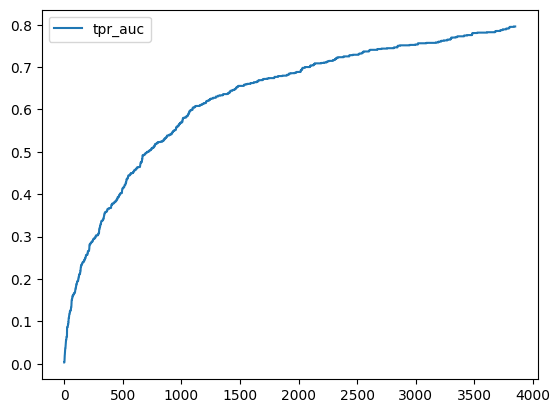

In [12]:
pd.DataFrame(tpr, columns=["tpr_auc"]).plot()

In [14]:
np.mean(results.iloc[0]["sizes_1_hop_alerted"])

np.float64(8.348333333333333)

In [15]:
np.mean(results.iloc[-1]["sizes_1_hop_alerted"])

np.float64(6.471666666666667)

In [19]:
results.iloc[0]["tpr_1%"]

np.float64(0.0029013539651837525)

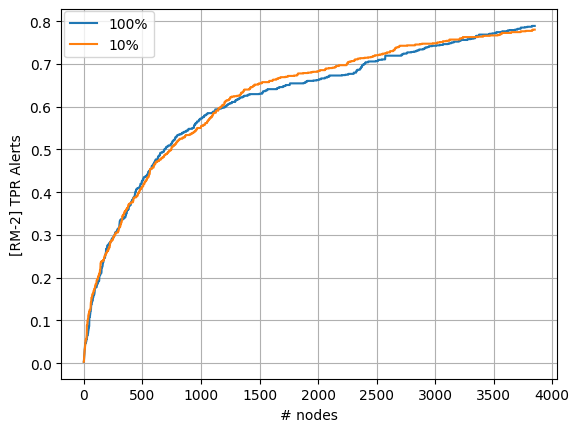

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for index, row in pd.read_parquet(f".{os.sep}results{os.sep}iter-ver.parquet").iterrows():
    if index not in [0, 6]:
        continue
    y = row["tpr_1%"]
    x = range(len(y))
    perc = round(row["rectify_perc"] * 100)
    if perc == 12:
        perc = 12.5
    ax.plot(x, y, label=f"{perc}%")
fig.legend(bbox_to_anchor=(0, 0.89, 0.28, 0))
ax.set(xlabel="# nodes", ylabel="[RM-2] TPR Alerts")
ax.grid()

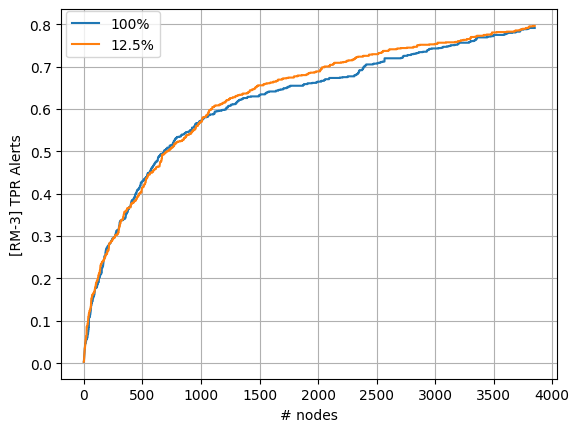

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for index, row in results.iterrows():
    if index not in [0, 3]:
        continue
    y = row["tpr_1%"]
    x = range(len(y))
    perc = round(row["rectify_perc"] * 100)
    if perc == 12:
        perc = 12.5
    ax.plot(x, y, label=f"{perc}%")
fig.legend(bbox_to_anchor=(0, 0.89, 0.29, 0))
ax.set(xlabel="# nodes", ylabel="[RM-3] TPR Alerts")
ax.grid()